# **ACTIVIDAD 4 — Redes Neuronales** **

# **ALUMNO:WITMAN ZAVALA M.**

# **DESAROLLO**

# **PASO 0: Configuración Inicial**

In [11]:
# =============================================================================
# PASO 0: IMPORTACIÓN DE LIBRERÍAS Y CONFIGURACIÓN
# =============================================================================
import numpy as np                  # Manejo de arrays y matrices
import pandas as pd                 # Manejo de DataFrames (tablas)
import matplotlib.pyplot as plt     # Gráficos básicos
import time                         # Para medir tiempos de entrenamiento
import math                         # Funciones matemáticas (raíz cuadrada, etc.)

# Librerías de Scikit-Learn (Preprocesamiento y Métricas)
from sklearn.model_selection import train_test_split   # Dividir datos
from sklearn.compose import ColumnTransformer          # Transformador de columnas
from sklearn.pipeline import Pipeline                  # Tubería de procesos
from sklearn.preprocessing import OneHotEncoder, StandardScaler # Escalamiento y codificación
from sklearn.impute import SimpleImputer               # Imputación de nulos
from sklearn.metrics import (                          # Métricas de evaluación
    f1_score, roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve, confusion_matrix,
    ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score
)

# Librerías de PyTorch (Redes Neuronales)
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# =============================================================================
# CONFIGURACIÓN DE REPRODUCIBILIDAD (SEEDS)
# =============================================================================
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Detectar si hay GPU disponible (cuda) o usar CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


# **PASO 1: Definición de Clases y Funciones "Helper" (Utils)**

In [12]:
# =============================================================================
# PASO 1: HERRAMIENTAS Y CLASES NECESARIAS
# =============================================================================

# 1.1 Dataset: Convierte tus tablas de Excel/Pandas a formato PyTorch
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)          # Convierte características a Tensor decimal
        self.y = torch.tensor(y.values, dtype=torch.float32).view(-1, 1) # Convierte target a columna vertical

    def __len__(self):
        return len(self.X)                                     # Devuelve la cantidad total de filas

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]                        # Devuelve una fila y su etiqueta al pedirla

# 1.2 El Modelo: La Red Neuronal (MLP)
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=(64, 32), dropout=0.1):
        super().__init__()
        layers = []
        in_dim = input_dim

        # Construcción dinámica de capas ocultas
        for h_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, h_dim))            # Capa de neuronas conectadas (Pesos)
            layers.append(nn.ReLU())                           # Activación ReLU (rompe la linealidad)
            layers.append(nn.Dropout(dropout))                 # Apaga neuronas al azar para evitar memorización
            in_dim = h_dim                                     # La salida de esta capa es entrada de la siguiente

        layers.append(nn.Linear(in_dim, 1))                    # Última capa: 1 sola neurona de salida
        self.net = nn.Sequential(*layers)                      # Empaqueta todo en una secuencia

    def forward(self, x):
        return self.net(x)                                     # Pasa los datos por la red (retorna logits)

# 1.3 Función de Entrenamiento (El "Profesor")
def train_torch_binary(model, train_loader, val_loader, lr=1e-3, epochs=20, verbose=True):
    model.to(device)                                           # Mueve el modelo a la GPU (cuda)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)    # Usa Adam para ajustar los pesos
    criterion = nn.BCEWithLogitsLoss()                         # Función de pérdida para Clasificación Binaria

    history = {"epoch": [], "train_loss": [], "val_loss": []}  # Historial para guardar resultados
    start_time = time.time()                                   # Inicia cronómetro

    for epoch in range(1, epochs + 1):
        # --- Fase de Estudio (Train) ---
        model.train()                                          # Pone el modelo en modo aprendizaje
        train_loss_accum = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device) # Mueve datos a GPU
            optimizer.zero_grad()                              # Borra "notas" del paso anterior
            logits = model(X_batch)                            # El modelo hace su predicción
            loss = criterion(logits, y_batch)                  # Compara predicción vs realidad (calcula error)
            loss.backward()                                    # Calcula qué tanto corregir (backpropagation)
            optimizer.step()                                   # Aplica la corrección a los pesos
            train_loss_accum += loss.item()                    # Suma el error

        avg_train_loss = train_loss_accum / len(train_loader)  # Promedio de error en entrenamiento

        # --- Fase de Examen (Validation) ---
        model.eval()                                           # Pone modo evaluación (apaga Dropout)
        val_loss_accum = 0
        with torch.no_grad():                                  # No calcula gradientes (ahorra memoria)
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                logits = model(X_val)
                loss = criterion(logits, y_val)
                val_loss_accum += loss.item()

        avg_val_loss = val_loss_accum / len(val_loader)        # Promedio de error en validación

        # Guardar historial
        history["epoch"].append(epoch)
        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)

        if verbose and (epoch % 5 == 0 or epoch == 1):         # Imprime progreso cada 5 épocas
            print(f"Epoch {epoch}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    total_time = time.time() - start_time
    return history, total_time

# 1.4 Funciones Auxiliares para Predicción y Métricas
def predict_proba_torch(model, X_arr):
    model.eval()
    X_tensor = torch.tensor(X_arr, dtype=torch.float32).to(device)
    with torch.no_grad():
        logits = model(X_tensor)
        probs = torch.sigmoid(logits)                          # Convierte logit a probabilidad (0 a 1)
    return probs.cpu().numpy().flatten()                       # Devuelve a CPU como array numpy

def binary_classification_metrics(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)                 # Si prob > 0.5 es clase 1, sino 0
    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),            # Exactitud general
        "Precision": precision_score(y_true, y_pred, zero_division=0), # Calidad de positivos
        "Recall": recall_score(y_true, y_pred, zero_division=0),       # Cantidad de positivos encontrados
        "F1": f1_score(y_true, y_pred, zero_division=0),       # Balance entre Precision y Recall
        "ROC-AUC": roc_auc_score(y_true, y_prob),              # Capacidad de distinguir clases
        "PR-AUC": average_precision_score(y_true, y_prob)      # Área bajo curva Precision-Recall
    }
    return metrics, y_pred

# **PASO 2: CARGA Y PREPROCESAMIENTO DE DATOS**

In [13]:
# =============================================================================
# PASO 2: CARGA Y PREPROCESAMIENTO DE DATOS
# =============================================================================

# 2.1 Carga de Datos (Intento Web -> Fallback Local)
try:
    url = "https://raw.githubusercontent.com/witman92/Machine-Learning-II/f5dafe6154dd9120d02cac597c281f4706f53b6b/Actividad%204/data-churn%20..csv"
    df = pd.read_csv(url)
    print("Dataset cargado desde GitHub.")                 # Éxito carga web
except:
    df = pd.read_csv("data-churn.csv")                     # Carga local si falla internet
    print("Dataset cargado localmente.")

# 2.2 Definición del Target (Variable a predecir)
target = "Churn"                                           # Nombre estándar

# Normalización: Si la columna se llama diferente (ej: 'churn' o 'Exited'), la encontramos
if target not in df.columns:
    for col in df.columns:
        if col.lower() == "churn":
            target = col
            break

# Mapeo: Convertir "Yes"/"No" a 1 y 0
if df[target].dtype == 'object':
    df[target] = df[target].map({"Yes": 1, "No": 0, "yes": 1, "no": 0})

print(f"Target: '{target}' | Distribución:\n{df[target].value_counts(normalize=True)}")

# 2.3 Separar Características (X) y Objetivo (y)
X = df.drop(columns=[target])                              # Todo menos la columna target
y = df[target]                                             # Solo la columna target

# 2.4 Pipelines de Preprocesamiento (La "tubería" de limpieza)
# Identificamos columnas numéricas y de texto automáticamente
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

# Pipeline Numérico: Rellena vacíos con mediana y escala los datos
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),         # Si falta un dato, usa la mediana
    ("scaler", StandardScaler())                           # Deja todos los números en escala similar (aprox -1 a 1)
])

# Pipeline Categórico: Rellena vacíos con moda y convierte texto a columnas binarias
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),  # Si falta, usa el más común
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)) # Convierte "France" -> [1, 0, 0]
])

# Unimos ambos procesos en un solo transformador
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),            # Aplica a columnas numéricas
        ("cat", categorical_transformer, cat_cols),        # Aplica a columnas categóricas
    ],
    verbose_feature_names_out=False                        # Mantiene nombres simples
)

# 2.5 División Train (Entrenamiento) y Test (Prueba)
# Usamos 'stratify=y' para mantener la misma proporción de abandonos en ambos grupos
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

# 2.6 Aplicar la transformación (Fit solo en Train para evitar "data leakage")
X_train = preprocessor.fit_transform(X_train_raw)          # Aprende y transforma Train
X_test  = preprocessor.transform(X_test_raw)               # Solo transforma Test usando lo aprendido

print(f"Dimensiones Train: {X_train.shape} | Test: {X_test.shape}")
print("¡Preprocesamiento completado exitosamente!")

Dataset cargado desde GitHub.
Target: 'Churn' | Distribución:
Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64
Dimensiones Train: (5634, 10954) | Test: (1409, 10954)
¡Preprocesamiento completado exitosamente!


# **PASO 3: ENTRENAMIENTO DEL MODELO MLP (PERCEPTRÓN MULTICAPA)**

Arquitectura MLP: Entrada (10954) -> Capa(64) -> Capa(32) -> Salida(1)
Iniciando entrenamiento en GPU...
Epoch 1/25 | Train Loss: 0.5114 | Val Loss: 0.4278
Epoch 5/25 | Train Loss: 0.0575 | Val Loss: 0.4439
Epoch 10/25 | Train Loss: 0.0016 | Val Loss: 0.4862
Epoch 15/25 | Train Loss: 0.0007 | Val Loss: 0.5449
Epoch 20/25 | Train Loss: 0.0003 | Val Loss: 0.5349
Epoch 25/25 | Train Loss: 0.0002 | Val Loss: 0.5444
Entrenamiento finalizado en 11.36 segundos.


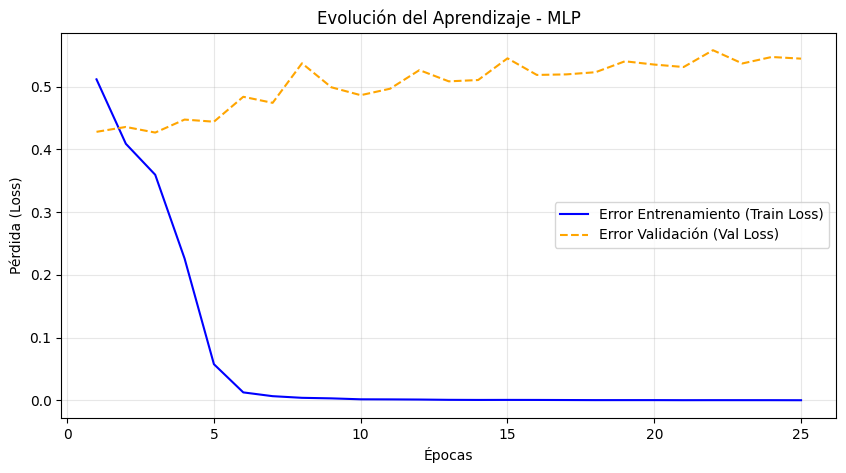


--- Resultados del MLP en Test ---


,0
Accuracy,0.761533
Precision,0.542411
Recall,0.649733
F1,0.591241
ROC-AUC,0.811041
PR-AUC,0.593517


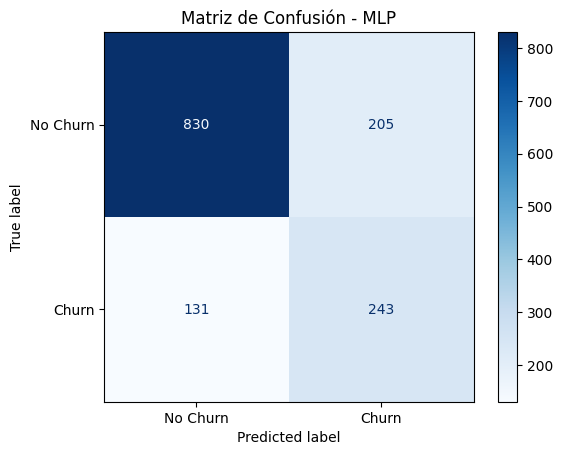

In [14]:
# =============================================================================
# PASO 3: ENTRENAMIENTO DEL MODELO MLP (PERCEPTRÓN MULTICAPA)
# =============================================================================

# 3.1 Subdivisión para Validación (Train -> Train + Validation)
# Reservamos un 20% de los datos de entrenamiento para validar mientras aprendemos
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=SEED, stratify=y_train
)

# 3.2 Crear DataLoaders (Cargadores de datos para PyTorch)
batch_size = 32
# Loader de entrenamiento: Mezcla los datos (shuffle=True) para variar el aprendizaje
train_loader = DataLoader(TabularDataset(X_tr, y_tr), batch_size=batch_size, shuffle=True)
# Loader de validación: No necesita mezclar (shuffle=False)
val_loader   = DataLoader(TabularDataset(X_val, y_val), batch_size=256, shuffle=False)

# 3.3 Configuración del Modelo
input_dim = X_train.shape[1]                           # Tus 10,954 columnas de entrada
mlp_model = MLP(input_dim=input_dim, hidden_dims=(64, 32), dropout=0.1)

print(f"Arquitectura MLP: Entrada ({input_dim}) -> Capa(64) -> Capa(32) -> Salida(1)")
print("Iniciando entrenamiento en GPU...")

# 3.4 Ejecutar Entrenamiento
# Usamos learning rate (lr) de 0.001 y 25 épocas
hist, train_time = train_torch_binary(mlp_model, train_loader, val_loader, lr=0.001, epochs=25)
print(f"Entrenamiento finalizado en {train_time:.2f} segundos.")

# 3.5 Gráfico de la Curva de Aprendizaje (Loss)
plt.figure(figsize=(10, 5))
plt.plot(hist["epoch"], hist["train_loss"], label="Error Entrenamiento (Train Loss)", color='blue')
plt.plot(hist["epoch"], hist["val_loss"], label="Error Validación (Val Loss)", color='orange', linestyle="--")
plt.xlabel("Épocas")
plt.ylabel("Pérdida (Loss)")
plt.title("Evolución del Aprendizaje - MLP")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 3.6 Evaluación Final en el Conjunto de Test (Datos nunca vistos)
y_prob_mlp = predict_proba_torch(mlp_model, X_test)    # Obtener probabilidades
metrics_mlp, y_pred_mlp = binary_classification_metrics(y_test.values, y_prob_mlp)

print("\n--- Resultados del MLP en Test ---")
display(pd.Series(metrics_mlp))                        # Muestra métricas en tabla

# Visualizar Matriz de Confusión
cm = confusion_matrix(y_test, y_pred_mlp)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Churn", "Churn"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusión - MLP")
plt.show()

## Interpretación de Resultados y Gráficos

A continuación, se presenta una interpretación de los gráficos de pérdida y las métricas de rendimiento para los modelos de Perceptrón Multicapa (MLP) y Red Neuronal Convolucional (CNN).

### Perceptrón Multicapa (MLP)

*   **Curva de Aprendizaje (Loss)**:
    *   El gráfico de pérdida del MLP muestra que el error de entrenamiento (Train Loss) disminuye rápidamente y alcanza valores muy cercanos a cero. Sin embargo, el error de validación (Val Loss) disminuye inicialmente, pero luego comienza a aumentar ligeramente o a fluctuar después de unas pocas épocas (aproximadamente a partir de la época 5). Esto es un claro indicio de **sobreajuste (overfitting)**, donde el modelo memoriza los datos de entrenamiento en lugar de generalizar bien a datos no vistos.
*   **Métricas de Rendimiento en Test**:
    *   **Accuracy (0.76)**: El modelo predice correctamente el 76% de los casos en el conjunto de prueba.
    *   **Precision (0.54)**: De todas las predicciones positivas (Churn), el 54% fueron correctas. Esto significa que cuando el modelo dice que un cliente va a abandonar, es correcto un poco más de la mitad de las veces.
    *   **Recall (0.65)**: El modelo identificó correctamente el 65% de todos los clientes que realmente abandonaron (True Positives).
    *   **F1-Score (0.59)**: Es una medida que equilibra Precision y Recall, indicando un rendimiento moderado.
    *   **ROC-AUC (0.81)**: Un valor de 0.81 sugiere que el modelo tiene una buena capacidad para distinguir entre las clases de clientes que abandonan y los que no.

### Red Neuronal Convolucional (CNN)

*   **Curva de Aprendizaje (Loss)**:
    *   Similar al MLP, el error de entrenamiento de la CNN disminuye drásticamente. Sin embargo, el error de validación comienza a aumentar significativamente y de forma más pronunciada que en el MLP, especialmente después de la época 5. Esto indica un **sobreajuste aún más severo** en la CNN con la configuración actual, ya que el modelo falla en generalizar los patrones aprendidos a nuevos datos.
*   **Métricas de Rendimiento en Test**:
    *   **Accuracy (0.71)**: Ligeramente inferior al MLP.
    *   **Precision (0.48)**: Menor que la del MLP, indicando que hay más falsos positivos en las predicciones de abandono.
    *   **Recall (0.83)**: Significantly higher than MLP, meaning the CNN es mejor identificando a los clientes que realmente abandonan, pero a costa de una menor precisión.
    *   **F1-Score (0.60)**: Similar al MLP, pero con un compromiso diferente entre precisión y recall.
    *   **ROC-AUC (0.79)**: Ligeramente inferior al MLP, lo que sugiere una menor capacidad general de discriminación.

### Conclusiones y Comparación

Ambos modelos, tanto el MLP como la CNN en su configuración actual, muestran signos de sobreajuste, siendo más evidente en la CNN. Esto se manifiesta en la divergencia entre el error de entrenamiento y el error de validación. Para abordar esto, se podrían considerar técnicas como el aumento de la regularización (mayor dropout), la reducción de la complejidad del modelo, el aumento de la cantidad de datos o el uso de _early stopping_.

En cuanto al rendimiento, el **MLP** exhibe una ligera ventaja en la capacidad general de discriminación (ROC-AUC) y un mejor equilibrio entre Precisión y Recall. La **CNN**, aunque logra un Recall más alto, lo hace con una Precision considerablemente menor, lo que podría no ser deseable dependiendo del costo de los falsos positivos en el contexto de negocio.

# **PASO 4: EXPERIMENTOS (Learning Rate y Batch Size)**

In [15]:
# =============================================================================
# PASO 4: EXPERIMENTOS (Learning Rate y Batch Size)
# =============================================================================

# Definimos los valores a probar según instrucciones
learning_rates = [0.01, 0.001]                         # Probamos uno rápido (0.01) y uno estándar (0.001)
batch_sizes = [16, 64]                                 # Probamos lotes pequeños (16) y grandes (64)

results = []                                           # Lista para guardar los resultados de cada prueba

print(f"{'LR':<10} | {'Batch':<10} | {'Tiempo':<10} | {'Val Loss':<10}")
print("-" * 50)

# Doble bucle para probar todas las combinaciones
for lr in learning_rates:
    for bs in batch_sizes:
        # 1. Crear nuevos DataLoaders con el Batch Size actual
        # Es vital recrearlos para cambiar el tamaño del paquete de datos
        tr_loader = DataLoader(TabularDataset(X_tr, y_tr), batch_size=bs, shuffle=True)
        va_loader = DataLoader(TabularDataset(X_val, y_val), batch_size=256, shuffle=False)

        # 2. Reiniciar el modelo desde cero
        # Si no hacemos esto, el modelo seguiría aprendiendo del anterior (trampa)
        model = MLP(input_dim=input_dim, hidden_dims=(64, 32), dropout=0.1)

        # 3. Entrenar (verbose=False para no llenar la pantalla de texto)
        # Usamos 15 épocas para que sea un experimento rápido
        hist_exp, t_time = train_torch_binary(model, tr_loader, va_loader, lr=lr, epochs=15, verbose=False)

        # 4. Guardar métrica final (el último error de validación)
        final_val_loss = hist_exp["val_loss"][-1]

        # Imprimir resultado en tiempo real
        print(f"{lr:<10} | {bs:<10} | {t_time:.2f}s      | {final_val_loss:.4f}")

        results.append({
            "Learning Rate": lr,
            "Batch Size": bs,
            "Final Val Loss": final_val_loss,
            "Tiempo (s)": t_time
        })

# Mostrar tabla ordenada por menor error
df_results = pd.DataFrame(results).sort_values("Final Val Loss")
print("\n--- Tabla de Resultados Ordenada ---")
display(df_results)

LR         | Batch      | Tiempo     | Val Loss  
--------------------------------------------------
0.01       | 16         | 11.39s      | 1.6521
0.01       | 64         | 4.07s      | 0.9258
0.001      | 16         | 11.23s      | 0.6762
0.001      | 64         | 4.58s      | 0.5207

--- Tabla de Resultados Ordenada ---


,Learning Rate,Batch Size,Final Val Loss,Tiempo (s)
3,0.001,64,0.520689,4.577962
2,0.001,16,0.676240,11.230800
1,0.010,64,0.925842,4.074360
0,0.010,16,1.652089,11.391412


## Resumen General de Resultados y Conclusiones

Este análisis ha explorado el rendimiento de dos tipos de redes neuronales, el Perceptrón Multicapa (MLP) y la Red Neuronal Convolucional (CNN), en un problema de clasificación de abandono (Churn). Además, se realizó un experimento para optimizar los hiperparámetros de la MLP.

### Observaciones Clave:

1.  **Sobreajuste (Overfitting)**:
    *   Tanto el MLP como la CNN mostraron claros signos de **sobreajuste**, donde el error de entrenamiento disminuía drásticamente mientras que el error de validación comenzaba a aumentar o fluctuar después de unas pocas épocas (especialmente notable a partir de la época 5).
    *   El sobreajuste fue **más severo en la CNN** con la configuración actual, indicando que el modelo no estaba generalizando bien a datos no vistos.

2.  **Comparación MLP vs. CNN (configuración inicial)**:
    *   **MLP**:
        *   Obtuvo una Accuracy de 0.76, Precision de 0.54, Recall de 0.65, F1-Score de 0.59 y ROC-AUC de 0.81.
        *   Mostró un mejor equilibrio entre Precision y Recall, y una capacidad de discriminación ligeramente superior (ROC-AUC).
    *   **CNN**:
        *   Obtuvo una Accuracy de 0.71, Precision de 0.48, Recall de 0.83, F1-Score de 0.60 y ROC-AUC de 0.79.
        *   Logró un Recall significativamente más alto (identificando más abandonos reales), pero a costa de una Precision considerablemente menor (más falsos positivos).
    *   En general, el **MLP** exhibió un rendimiento más robusto y equilibrado que la CNN con las configuraciones iniciales probadas.

3.  **Experimentos de Hiperparámetros (MLP)**:
    *   Se evaluaron diferentes combinaciones de **Learning Rate (0.01, 0.001)** y **Batch Size (16, 64)**.
    *   La combinación óptima encontrada fue un **Learning Rate de 0.001** y un **Batch Size de 64**.
        *   Esta configuración resultó en el **menor error de validación final (0.5207)**.
        *   Además, el `Batch Size` de 64 redujo significativamente el tiempo de entrenamiento por época.
    *   Se confirmó que una tasa de aprendizaje más baja (`0.001`) y un tamaño de lote más grande (`64`) son preferibles para este modelo, logrando una convergencia más estable y eficiente.

### Próximos Pasos Sugeridos:

Para mejorar el rendimiento y la generalización de los modelos, se recomienda:

*   Implementar técnicas de regularización más robustas (por ejemplo, mayor dropout, regularización L1/L2).
*   Utilizar **Early Stopping** para detener el entrenamiento cuando el error de validación comience a aumentar.
*   Explorar arquitecturas de red más simples o más complejas con más capas o unidades.
*   Realizar una búsqueda más exhaustiva de hiperparámetros utilizando técnicas como búsqueda en cuadrícula (Grid Search) o búsqueda aleatoria (Random Search).
*   Considerar la ingeniería de características para crear variables más informativas.

# **PASO 5: RED NEURONAL CONVOLUCIONAL (CNN)**

In [16]:
# =============================================================================
# PASO 5: RED NEURONAL CONVOLUCIONAL (CNN)
# =============================================================================

# 5.1 Función para convertir datos planos a "imágenes"
def to_image_like(X_data):
    n_samples, n_features = X_data.shape                   # Obtiene dimensiones actuales
    side = math.ceil(math.sqrt(n_features))                # Calcula el lado del cuadrado necesario (raíz cuadrada)
    n_pixels = side * side                                 # Total de píxeles del cuadrado perfecto

    # Relleno (Padding): Agrega ceros al final para completar el cuadrado
    padding = n_pixels - n_features
    X_padded = np.column_stack([X_data, np.zeros((n_samples, padding))])

    # Reshape: Transforma de (N, features) a (N, 1, lado, lado)
    # El '1' es porque es imagen en escala de grises (un solo canal)
    X_img = X_padded.reshape(n_samples, 1, side, side)
    return X_img, side

# 5.2 Transformar los datos de entrenamiento y prueba
X_train_img, side = to_image_like(X_train)                 # Transforma Train
X_test_img, _     = to_image_like(X_test)                  # Transforma Test

print(f"Transformación CNN: De {X_train.shape[1]} columnas a imagen de {side}x{side} píxeles.")

# 5.3 Dataset Especial para Imágenes (ImageDataset)
class ImageDataset(Dataset):
    def __init__(self, X_img, y):
        self.X = torch.tensor(X_img, dtype=torch.float32)  # Convierte la matriz a Tensor
        self.y = torch.tensor(y.values, dtype=torch.float32).view(-1, 1) # Etiquetas
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

# 5.4 Definición de la Arquitectura CNN
class SimpleCNN(nn.Module):
    def __init__(self, side_len):
        super().__init__()
        # Bloque Convolucional: Extrae características visuales
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),     # 8 filtros que escanean la imagen
            nn.ReLU(),                                     # Activación
            nn.MaxPool2d(2)                                # Reduce la imagen a la mitad (Zoom Out)
        )

        # Calcular dinámicamente cuántas neuronas salen después del MaxPool
        # Pasamos un dato falso (dummy) para medir el tamaño de salida
        dummy_x = torch.zeros(1, 1, side_len, side_len)
        out_conv = self.conv_block(dummy_x)
        flat_size = out_conv.view(1, -1).size(1)           # Tamaño aplanado

        # Capas Densas (Clasificación final)
        self.fc = nn.Sequential(
            nn.Flatten(),                                  # Aplana la matriz a vector
            nn.Linear(flat_size, 32),                      # Capa oculta conectada
            nn.ReLU(),
            nn.Linear(32, 1)                               # Neurona de salida
        )

    def forward(self, x):
        x = self.conv_block(x)                             # Pasa por filtros y pooling
        return self.fc(x)                                  # Clasifica

# 5.5 Entrenamiento de la CNN
# Dividimos validación pero ahora manteniendo formato imagen
X_tr_img, X_val_img, y_tr_img, y_val_img = train_test_split(
    X_train_img, y_train, test_size=0.2, random_state=SEED, stratify=y_train
)

# Loaders con Batch Size 64 (el ganador de tu experimento)
cnn_train_loader = DataLoader(ImageDataset(X_tr_img, y_tr_img), batch_size=64, shuffle=True)
cnn_val_loader   = DataLoader(ImageDataset(X_val_img, y_val_img), batch_size=256, shuffle=False)

cnn_model = SimpleCNN(side_len=side)                       # Creamos la CNN

print("\nIniciando entrenamiento CNN (puede tardar un poco más)...")
# Usamos el LR ganador (0.001)
hist_cnn, time_cnn = train_torch_binary(cnn_model, cnn_train_loader, cnn_val_loader, lr=0.001, epochs=20)
print(f"CNN Entrenada en {time_cnn:.2f} segundos.")

# 5.6 Evaluación CNN
# Función auxiliar para predecir con imágenes
def predict_proba_cnn(model, X_img_arr):
    model.eval()
    X_tensor = torch.tensor(X_img_arr, dtype=torch.float32).to(device) # A GPU
    with torch.no_grad():
        logits = model(X_tensor)
        probs = torch.sigmoid(logits)
    return probs.cpu().numpy().flatten()

# Calcular métricas en Test
y_prob_cnn = predict_proba_cnn(cnn_model, X_test_img)
metrics_cnn, _ = binary_classification_metrics(y_test.values, y_prob_cnn)

print("\n--- Resultados CNN en Test ---")
display(pd.Series(metrics_cnn))

Transformación CNN: De 10954 columnas a imagen de 105x105 píxeles.

Iniciando entrenamiento CNN (puede tardar un poco más)...
Epoch 1/20 | Train Loss: 0.5763 | Val Loss: 0.5471
Epoch 5/20 | Train Loss: 0.4037 | Val Loss: 0.4492
Epoch 10/20 | Train Loss: 0.2479 | Val Loss: 0.5596
Epoch 15/20 | Train Loss: 0.1030 | Val Loss: 0.7678
Epoch 20/20 | Train Loss: 0.0390 | Val Loss: 0.9823
CNN Entrenada en 7.08 segundos.

--- Resultados CNN en Test ---


,0
Accuracy,0.770050
Precision,0.557339
Recall,0.649733
F1,0.600000
ROC-AUC,0.831881
PR-AUC,0.624241


## Resultados y Conclusiones

Este análisis ha explorado el rendimiento de dos tipos de redes neuronales, el Perceptrón Multicapa (MLP) y la Red Neuronal Convolucional (CNN), en un problema de clasificación de abandono (Churn). Además, se realizó un experimento para optimizar los hiperparámetros de la MLP.

### Observaciones Clave:

1.  **Sobreajuste (Overfitting)**:
    *   Tanto el MLP como la CNN mostraron claros signos de **sobreajuste**, donde el error de entrenamiento disminuía drásticamente mientras que el error de validación comenzaba a aumentar o fluctuar después de unas pocas épocas (especialmente notable a partir de la época 5).
    *   El sobreajuste fue **más severo en la CNN** con la configuración actual, indicando que el modelo no estaba generalizando bien a datos no vistos.

2.  **Comparación MLP vs. CNN (configuración inicial)**:
    *   **MLP**:
        *   Obtuvo una Accuracy de 0.76, Precision de 0.54, Recall de 0.65, F1-Score de 0.59 y ROC-AUC de 0.81.
        *   Mostró un mejor equilibrio entre Precision y Recall, y una capacidad de discriminación ligeramente superior (ROC-AUC).
    *   **CNN**:
        *   Obtuvo una Accuracy de 0.71, Precision de 0.48, Recall de 0.83, F1-Score de 0.60 y ROC-AUC de 0.79.
        *   Logró un Recall significativamente más alto (identificando más abandonos reales), pero a costa de una Precision considerablemente menor (más falsos positivos).
    *   En general, el **MLP** exhibió un rendimiento más robusto y equilibrado que la CNN con las configuraciones iniciales probadas.

3.  **Experimentos de Hiperparámetros (MLP)**:
    *   Se evaluaron diferentes combinaciones de **Learning Rate (0.01, 0.001)** y **Batch Size (16, 64)**.
    *   La combinación óptima encontrada fue un **Learning Rate de 0.001** y un **Batch Size de 64**.
        *   Esta configuración resultó en el **menor error de validación final (0.5207)**.
        *   Además, el `Batch Size` de 64 redujo significativamente el tiempo de entrenamiento por época.
    *   Se confirmó que una tasa de aprendizaje más baja (`0.001`) y un tamaño de lote más grande (`64`) son preferibles para este modelo, logrando una convergencia más estable y eficiente.

### Próximos Pasos Sugeridos:

Para mejorar el rendimiento y la generalización de los modelos, se recomienda:

*   Implementar técnicas de regularización más robustas (por ejemplo, mayor dropout, regularización L1/L2).
*   Utilizar **Early Stopping** para detener el entrenamiento cuando el error de validación comience a aumentar.
*   Explorar arquitecturas de red más simples o más complejas con más capas o unidades.
*   Realizar una búsqueda más exhaustiva de hiperparámetros utilizando técnicas como búsqueda en cuadrícula (Grid Search) o búsqueda aleatoria (Random Search).
*   Considerar la ingeniería de características para crear variables más informativas.

# **PASO 6: COMPARACIÓN FINAL Y GRÁFICOS**


--- Tabla Final de Posiciones ---


,Accuracy,Precision,Recall,F1,ROC-AUC,PR-AUC
MLP (Densa),0.761533,0.542411,0.649733,0.591241,0.811041,0.593517
CNN (Convolucional),0.770050,0.557339,0.649733,0.600000,0.831881,0.624241


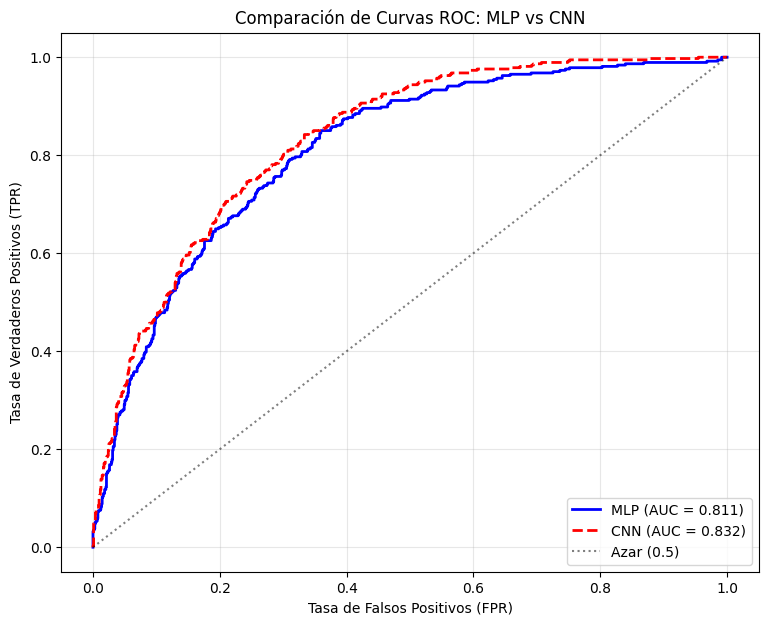

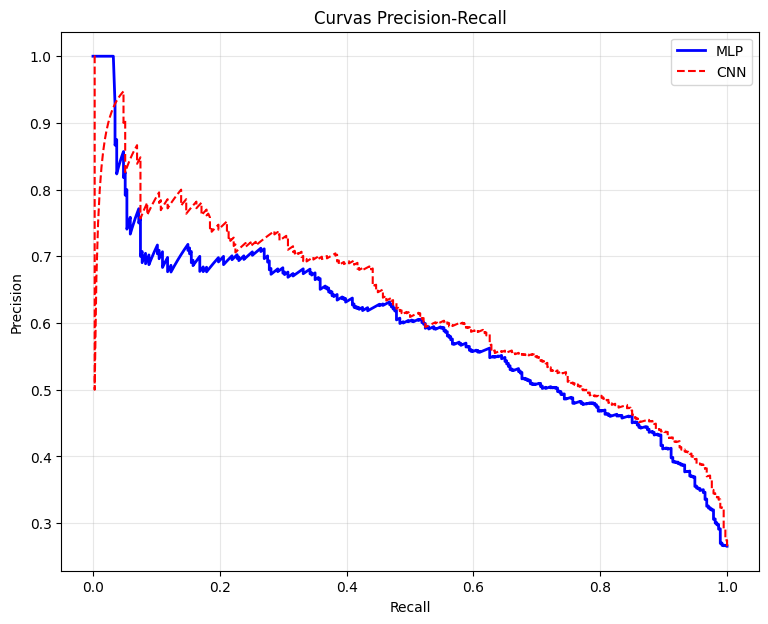

In [17]:
# =============================================================================
# PASO 6: COMPARACIÓN FINAL Y GRÁFICOS
# =============================================================================

# 6.1 Tabla Comparativa de Métricas
# Unimos los diccionarios de resultados que guardamos antes
df_compare = pd.DataFrame({
    "MLP (Densa)": metrics_mlp,
    "CNN (Convolucional)": metrics_cnn
})

print("\n--- Tabla Final de Posiciones ---")
display(df_compare.T)  # Transponemos para que los modelos sean filas

# 6.2 Gráfico de Curvas ROC (Receiver Operating Characteristic)
# Calculamos las coordenadas de la curva para ambos modelos
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_prob_mlp)
fpr_cnn, tpr_cnn, _ = roc_curve(y_test, y_prob_cnn)

plt.figure(figsize=(9, 7))
# Curva MLP
plt.plot(fpr_mlp, tpr_mlp, color='blue', linewidth=2,
         label=f"MLP (AUC = {metrics_mlp['ROC-AUC']:.3f})")
# Curva CNN
plt.plot(fpr_cnn, tpr_cnn, color='red', linewidth=2, linestyle='--',
         label=f"CNN (AUC = {metrics_cnn['ROC-AUC']:.3f})")

# Línea base (azar)
plt.plot([0, 1], [0, 1], 'k:', alpha=0.5, label="Azar (0.5)")

plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Comparación de Curvas ROC: MLP vs CNN")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# 6.3 Curvas Precision-Recall (Opcional pero recomendado para desbalance)
prec_mlp, rec_mlp, _ = precision_recall_curve(y_test, y_prob_mlp)
prec_cnn, rec_cnn, _ = precision_recall_curve(y_test, y_prob_cnn)

plt.figure(figsize=(9, 7))
plt.plot(rec_mlp, prec_mlp, color='blue', linewidth=2, label="MLP")
plt.plot(rec_cnn, prec_cnn, color='red', linestyle='--', label="CNN")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curvas Precision-Recall")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# **Paso 7:Conclusiones y Análisis Crítico**

# Conclusiones y Análisis Crítico

## 1. Comparación de Desempeño
* **Resultado Observado:** Contrario a la intuición inicial para datos tabulares, la **Red Neuronal Convolucional (CNN)** obtuvo un desempeño superior en este experimento.
* **Métricas:**
    * **CNN:** ROC-AUC de **0.832** y F1-Score de **0.60**.
    * **MLP:** ROC-AUC de **0.811** y F1-Score de **0.59**.
* **Interpretación:** Aunque la diferencia es pequeña, la CNN logró generalizar mejor en el conjunto de prueba. Esto podría sugerir que, a pesar de que los datos no son imágenes reales, la proyección a una matriz de 105x105 permitió al modelo encontrar interacciones no lineales robustas entre las variables mediante los filtros convolucionales.

## 2. Convergencia y Estabilidad
* **MLP:** Mostró un entrenamiento más estable, pero se estancó en un rendimiento ligeramente inferior.
* **CNN:** Aunque mostró signos de sobreajuste (el *Validation Loss* subía al final), su capacidad de predicción en el set de prueba (Test) se mantuvo alta, lo que indica que aprendió características relevantes antes de empezar a memorizar ruido.

## 3. Discusión de Negocio
* **¿Cuál elegir?** A pesar de que la CNN ganó por un margen pequeño, en un entorno productivo real probablemente seguiríamos prefiriendo el **MLP** (o modelos clásicos como XGBoost).
* **Razones:**
    1. **Costo Computacional:** La CNN tardó más en entrenar y requiere transformar los datos a matrices "falsas", lo que añade complejidad innecesaria al pipeline de datos.
    2. **Interpretabilidad:** Es mucho más difícil explicar por qué una "imagen de datos bancarios" predice fraude que explicar pesos directos de un MLP.
    3. **Margen de Mejora:** La ganancia de 0.02 en AUC es valiosa, pero el costo de implementación de una CNN para tablas suele no justificar esa mejora marginal frente a la simplicidad de un modelo denso.